In [1]:
#Load in necessary modules and packages

import os
import numpy as np
import scipy.io.wavfile as sio_wav
import scipy.signal as sp_sig
import matplotlib.pyplot as plt
from signal_utils import *
%matplotlib inline
import keras
from keras.models import model_from_json
from tl_model.inner_hair_cell2018 import inner_hair_cell_potential
from tl_model.auditory_nerve2018 import auditory_nerve_fiber
from CI_processing import *
import warnings
warnings.filterwarnings("ignore")

### 1.1
Basic functionality of the HiRes 120 processing strategy, currently used in the Advanced Bionics implant. The algorithm is adopted from the [Generic Python Toolbox (GpyT)](https://github.com/jabeim/AB-Generic-Python-Toolbox), a Python port of [GMT](https://github.com/jabeim/GMT). For more information refer to the corresponding [documentation](https://github.com/jabeim/AB-Generic-Python-Toolbox/raw/master/Documentation%20__draft__v0.1.docx). 

In [2]:
# PyAudio and the Generic Python Toolbox (GpyT) need to be installed to run this section
import GpyT
from pipelineTemplate import processingPipeline

results = processingPipeline("example.wav") # simulate HiRes120 processing for an audio file
ci_pulses_hires120 = results['elGram'] # Simulated electrical pulses generated by the cochlear implant over time 
ci_pulses_hires120_pos = np.clip(ci_pulses_hires120,0,None) # keep only the positive polarities for this example
cf_hires120 = np.mean(results['sig_3frm_peakFreq'],axis=1) # approximate CFs of each channel
# The pulses are also passed to a vocoder function to simulate the sound perceived by a cochlear implant user
# in response to the given electrode matrix. 
vocoded_audio = results['audioOut']
vocoded_audio_fs = results['audioFs']

# read the wavfile
wavfile = 'example.wav'
fs, signal = sio_wav.read(wavfile) 
if signal.dtype != 'float32': # scipy returns a quantized signal - scale it back
    if signal.dtype == 'int16':
        nb_bits = 16 # -> 16-bit wav files
    elif signal.dtype == 'int32':
        nb_bits = 32 # -> 32-bit wav files
    max_nb_bit = float(2 ** (nb_bits - 1))
    signal = signal / (max_nb_bit + 1.0) # scale the signal to [-1.0,1.0]
    
fs_hires120 = int(fs*ci_pulses_hires120.shape[1]/len(signal))
t = np.arange(len(signal))/fs
t_hires120 = np.arange(ci_pulses_hires120.shape[1])/fs_hires120

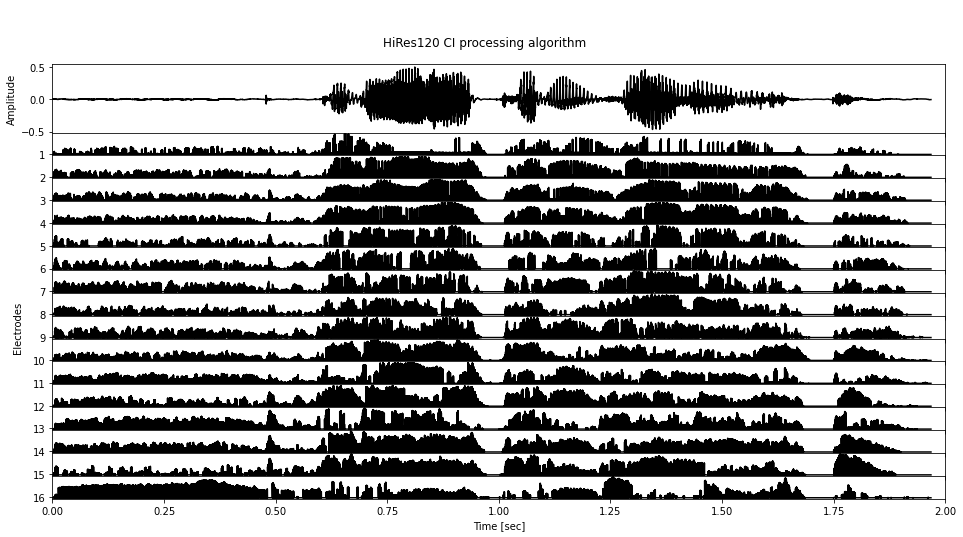

In [3]:
# plot the input audio stimulus and the output electrodogram over time
nsubplots = ci_pulses_hires120.shape[0] + 1
height_ratios = [1]*nsubplots
height_ratios[0] = 3
fig, axs = plt.subplots(nsubplots,figsize=(16,8), sharex=True, sharey=False, gridspec_kw={'hspace': 0, 'height_ratios': height_ratios})
fig.suptitle('\n\nHiRes120 CI processing algorithm')
axs[0].plot(t,signal,'k')
axs[0].set_ylabel('Amplitude');
for i in range (1,nsubplots):
    axs[i].plot(t_hires120,ci_pulses_hires120_pos[i-1,:],'k') # plot only the positive polarities
    axs[i].label_outer()
    axs[i].set_yticks([i])
axs[i].set_xlabel('Time [sec]'); axs[i].set_xlim([0,2]); axs[9].set_ylabel('Electrodes\n');

sio_wav.write("vocoded_example.wav", vocoded_audio_fs, vocoded_audio)
# This saves the vocoded audio signal to a wavfile. 
# You can listen to it to experience how a cochlear implant sounds like.

Starting with the fact that the CI method only computes the positive spikes and the HiRes120 algorithm shows both positive and negative values, the outputs from the two algorithms are different. A change in the amplitude is also present. The CI method returns amplitudes that are greater than those of the HiRes120, and this difference is particularly apparent in the higher peaks.

When comparing the two, the HiRes offers a more accurate representation of a real CI algorithm and also offers more information with the 16 channels of the various CFs for each.

### 1.2
Comparison of a paradigm multichannel CI processing algorithm (based on HiRes) against the auditory-nerve performance of the NH human auditory system. 

In [4]:
# Fixed parameters
fs_tl = 100e3 # the IHC model requires a 100kHz sampling frequency
resting_potential = -0.05703; # resting_potential at equilibrium of the reference IHC model
fs_nn = 20e3 # CoNNear requires 20kHz
cf_nn = np.loadtxt('cf_connear.txt')*1e3 # Frequency channels of the reference model
# General parameters
L = 70. # specify the desired SPL of the input
fs_ci = 16e3 # sampling frequency of the CI algorithm
M = 16 # number of frequency channels to use for the CI algorithm
cf_ci = np.logspace(2.5441,3.7404,num=M) # Center frequencies of the bands of the CI algorithm - 350 to 5500 Hz

# read the wavfile
wavfile = 'example.wav'
fs, signal = sio_wav.read(wavfile) 
if signal.dtype != 'float32': # scipy returns a quantized signal - scale it back
    if signal.dtype == 'int16':
        nb_bits = 16 # -> 16-bit wav files
    elif signal.dtype == 'int32':
        nb_bits = 32 # -> 32-bit wav files
    max_nb_bit = float(2 ** (nb_bits - 1))
    signal = signal / (max_nb_bit + 1.0) # scale the signal to [-1.0,1.0]

#use some part of the audio signal
sample_duration = 1 #needs to be in seconds
onset_duration = 0.5 #omit silence in the beginning (secs)
num_samples = int(sample_duration * fs)
onset_samples = int(onset_duration * fs)
signal = signal[onset_samples:onset_samples+num_samples]
#adjust the SPL to the desired level
signal = adjust_spl(signal, L)

Simulate the auditory-nerve (AN) outputs of the auditory model (cochlea-IHC-AN) to the input stimulus

In [5]:
#load the CoNNear cochlear model
json_file = open("connear/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
connear = model_from_json(loaded_model_json)
connear.load_weights("connear/Gmodel.h5")
connear.summary()

#Generate CoNNear features
if fs != fs_nn :
    print("Resampling signal to " + str(fs_nn) + " Hz")
    signal_nn = sp_sig.resample_poly(signal, fs_nn, fs)
else:
    signal_nn = signal
#The CoNNear model needs an (1,x,1) input, hence expanding the dimensions
signal_nn = np.expand_dims(signal_nn, axis=0)
signal_nn = np.expand_dims(signal_nn, axis=2)
nn_out = connear.predict(signal_nn)
nn_out = nn_out[0,:,:] * 1e-6 # cochlear scaling

#Find the corresponding frequency channels of the CI algorithm in the reference model CFs and keep only those channels
#dims: N x channels
indx = [] 
for n in range(len(cf_ci)): 
    indx.append(np.abs(cf_nn-cf_ci[n]).argmin())  
tl_out = nn_out[:,indx] # keep those channels
cf_tl=cf_nn[indx] # the corresponding channels for the reference model
#resample to the original tl model sampling frequency (100 kHz) for feeding to the IHC stage
tl_out = sp_sig.resample_poly(tl_out, fs_tl, fs_nn)

#Now run the cohlear output through IHC and AN model
IHCrange = 0.118
IHC_out = inner_hair_cell_potential(tl_out*IHCrange,fs_tl) #should have the size of [N,channels]
#now downsample to the CI algorithm sampling frequency
IHC_out_ds=sp_sig.resample_poly(IHC_out, fs_ci, fs_tl) #downsampled
# AN_NH are the simulated AN outputs of the reference model
AN_NH = auditory_nerve_fiber(IHC_out_ds,fs_ci,spont=2)*fs_ci #AN firing rate of an HSR fiber in spikes/sec

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_input (InputLayer)     [(None, None, 1)]         0         
_________________________________________________________________
model_1 (Functional)         (None, None, 201)         11689984  
Total params: 11,689,984
Trainable params: 11,689,984
Non-trainable params: 0
_________________________________________________________________
Resampling signal to 20000.0 Hz


Simulate the AN outputs to the CI processed auditory signal, using the reference AN model

In [6]:
# Resample the signal to feed it into the CI algorithm - fs = 16 kHz
if fs != fs_ci :
    print("Resampling signal to " + str(fs_ci) + " Hz")
    signal_ci = sp_sig.resample_poly(signal, fs_ci, fs)
else:
    signal_ci = signal
    
#Process the audio stimulus using the CI algorithm  
ci_pulses = ci_processing(signal_ci,M=M,Ts=0.001,pulsei=2,MCL=[],THL=[],IDR=60) 
#M = Size of the filterbank, default=16, type=int
#Ts = Duration of a stimulation cycle in secs, default=0.001, type=float
#pulsei = 1 for monophasic pulse, 2 for biphasic pulse", default=2, type=int
#MCL = List containing the Most Comfortable Level in dB-SPL for each frequency band", default=[])
#THL = List containing the Hearing Thresholds in dB-SPL for each frequency band", default=[])
#IDR = Input Dynamic Range, default=60, type=float
# output dimensions: channels x N

Magic_cte = 0.6 #to bring acoustic and electric hearing in the same range
CI_out = (ci_pulses.T * Magic_cte) + resting_potential # add the resting potential of the reference IHC model
# AN_CI are the AN outputs for the CI processed signal
AN_CI = auditory_nerve_fiber(CI_out,fs_ci,spont=2)*fs_ci #AN firing rate of an HSR fiber in spikes/sec

Resampling signal to 16000.0 Hz


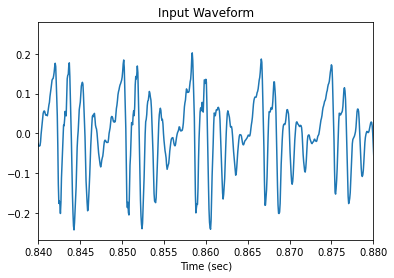

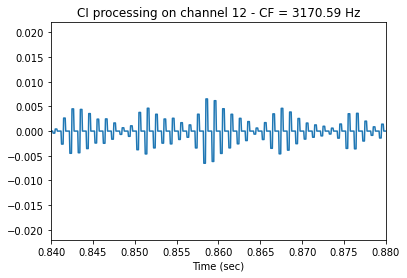

In [9]:
#freq = 1000 # frequency to plot
freq = 3000 # frequency to plot -> well above the phase-locking limit

channel = np.abs(cf_ci-freq).argmin() # find the CI channel with the closest frequency

t_ci = np.arange(len(signal_ci))/fs_ci
plt.figure()
plt.plot(t_ci,signal_ci), plt.title("Input Waveform")
plt.xlim([0.84,0.88])
plt.xlabel('Time (sec)')
plt.figure()
plt.plot(t_ci ,ci_pulses[channel,:])
plt.title("CI processing on channel " + str(channel) + " - CF = " + "%.2f" % cf_ci[channel] + " Hz")
plt.xlim([0.84,0.88])
plt.xlabel('Time (sec)')
plt.show()

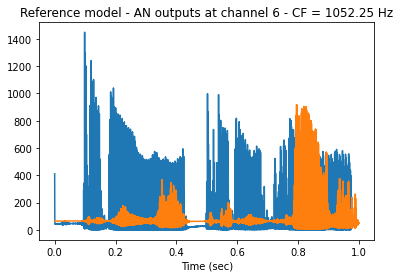

In [10]:
freq = 1000 # frequency to plot
channel = np.abs(cf_ci-freq).argmin() # find the CI channel with the closest frequency

t_nh = np.arange(AN_NH.shape[0])/fs_ci
plt.figure()
plt.plot(t_nh,AN_NH[:,channel])
plt.plot(t_ci,AN_CI[:,channel])
plt.title("Reference model - AN outputs at channel " + str(channel) + " - CF = " + "%.2f" % cf_tl[channel] + " Hz")
plt.xlabel('Time (sec)')
plt.show()

We can observe a person's natural hearing and the stimulation from a cochlear implant in the figure above when we compare the two models. The firing rates are shown in terms of time in the figure, and it is clear that the cochlear implant's signal processing is underperforming since the firing rates are too low in comparison to the reference model.

In [11]:
# uncomment to save the AN outputs to a mat file
AN_responses={'AN_NH': AN_NH,'AN_CI': AN_CI, 'cf': cf_tl}
print(f"center frequencies: {AN_responses['cf']}")
#scipy.io.savemat('AN_responses.mat', AN_responses)

center frequencies: [ 349.38726628  420.42869378  501.77015308  609.26947274  734.75858175
  881.24803421 1052.25219428 1279.06865559 1516.6472758  1831.76675532
 2206.8050459  2653.15548925 3184.37782919 3816.61014495 4569.05911227
 5464.58348566]


In [12]:
# uncomment if the above blocks don't work to load the pre-simulated AN outputs
# scipy.io.loadmat('AN_responses.mat', AN_responses)

### 1.4
Summed AN responses across all channels, simulated for the HiRes120 electrical pulses

In [13]:
# downsample the generated hires120 pulses to fs_ci
ci_pulses_hires120_ds=sp_sig.resample_poly(ci_pulses_hires120.T, fs_ci, fs_hires120)
#keep the same part of the audio signal
num_samples = int(sample_duration * fs_ci) # use sample_duration defined in subsection 1.1
onset_samples = int(onset_duration * fs_ci) # use onset_duration defined in subsection 1.1
ci_pulses_hires120_ds = ci_pulses_hires120_ds[onset_samples:onset_samples+num_samples,:]
# ci_pulses_hires120_ds contains the generated HiRes120 pulses for the same signal and sampling frequency 
# that was used in section 1.2

# Scale to the same amplitudes
Magic_cte_hires120 = 0.0001 # constant to bring acoustic and electric hearing in the same range
CI_out_hires120 = (ci_pulses_hires120_ds * Magic_cte_hires120) + resting_potential # add the resting potential of the reference IHC model
# Simulate the AN outputs
AN_CI_hires120 = auditory_nerve_fiber(CI_out_hires120,fs_ci,spont=2)*fs_ci #AN firing rate of an HSR fiber in spikes/sec
# Summed AN response
AN_CI_hires120_summed = np.sum(AN_CI_hires120,axis=1)

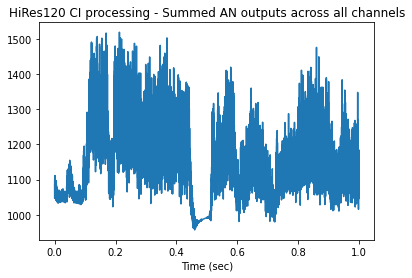

In [14]:
plt.figure()
plt.plot(t_ci,AN_CI_hires120_summed)
plt.title("HiRes120 CI processing - Summed AN outputs across all channels")
plt.xlabel('Time (sec)')
plt.show()